# Calculating distances to nearest neighbour from every pixel in grid
For this example, we will calculate the distance from each pixel in our grid to the closest sea ice edge pixel. We will use the monthly sea ice concentration output from ACCESS-OM2-01 over the Southern Ocean.  
  
**Contributors:** Denisse Fierro Arcos, Angus Gibson, Navid Constantinou, Ed Doddridge.

## Loading modules

In [1]:
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import datetime as dt
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt

## Creating a session in the COSIMA cookbook

In [2]:
session = cc.database.create_session()

## Accessing ACCESS-OM2-01 data
We will use monthly sea ice outputs from cycle four. For this example, we will load only two months of sea ice data. Note the use of `decode_coords = False`. This avoids lengthly delays in accessing sea ice data. See more information [here](https://forum.access-hive.org.au/t/issues-loading-access-om2-01-data-from-cycle-4/418/3).

In [3]:
var_ice = cc.querying.getvar('01deg_jra55v140_iaf_cycle4', 'aice_m', session, 
                             start_time = '1978-01', end_time = '1978-03',
                             decode_coords = False)

The sea ice outputs need some processing before we can start our calculations. You can check this [example](https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/IcePlottingExample.ipynb) for a guide on how to load and plot sea ice data.  
  
We will follow these processing steps:
1. Correct time dimension values by subtracting 12 hours,
2. Attach the ocean model grid so we can calculate distances.

In [4]:
#Loading area_t to get ocean grid
area_t = cc.querying.getvar('01deg_jra55v140_iaf_cycle4', 'area_t', session, n = 1)

#Apply time correction so data appears in the middle (12:00) of the day rather than at the beginning of the day (00:00)
var_ice['time'] = var_ice.time.to_pandas() - dt.timedelta(hours = 12)

#Change coordinates so they match ocean dimensions 
var_ice.coords['ni'] = area_t['xt_ocean'].values
var_ice.coords['nj'] = area_t['yt_ocean'].values

#Rename coordinate variables so they match ocean data
var_ice = var_ice.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

#Subetting data for the Southern Ocean
var_ice = var_ice.sel(yt_ocean = slice(-80, -45))

#Checking results
var_ice

<xarray.DataArray 'aice_m' (time: 3, yt_ocean: 713, xt_ocean: 3600)>
dask.array<getitem, shape=(3, 713, 3600), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1977-12-31T12:00:00 ... 1978-02-28T12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    coordinates:    TLON TLAT time
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

## Finding sea ice edge
The sea ice edge is the defined as the northernmost areas where sea ice concentration (SIC) is under $10\%$. This is a multistep process:
1. Identify pixels where SIC is greater or equal to 0.1, and change value to 1,
2. Calculate cumulate sum along y axis,
3. Apply mask to remove original NA values from cumulative.

This will result in pixels with the highest value along the y axis to be identified as the sea ice edge. 

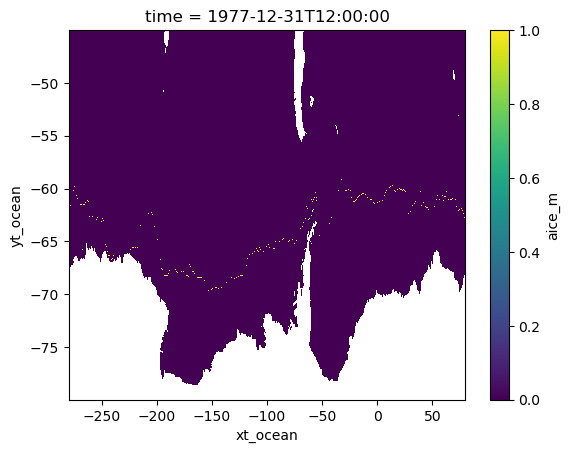

In [5]:
#Assign a value of 1 to any areas where SIC is at least 0.1
ice_10 = xr.where(var_ice >= 0.1, 1, np.nan)

#Adding all cells along y axis. Masking out NA values
ice_10 = ice_10.cumsum(dim = 'yt_ocean', skipna = True).where(~np.isnan(ice_10))

#Finding cells with highest value along y axis. This identifies the ice edge at each longitude.
ice_10 = xr.where(ice_10 == ice_10.max('yt_ocean'), 1, 0).where(~np.isnan(var_ice))

#Checking result for first time step
ice_10[0].plot()

### Checking results in relation to SIC data

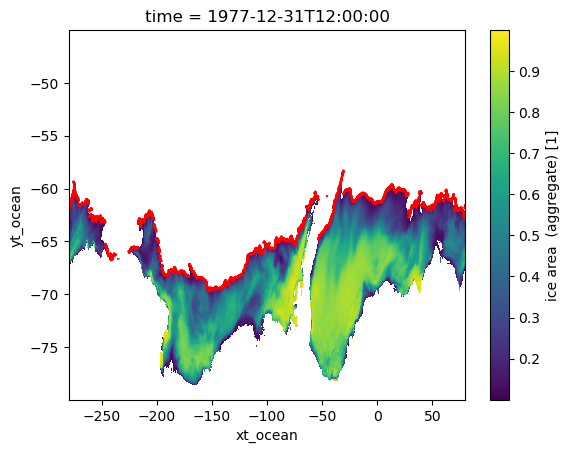

In [6]:
#Checking results for first time step
fig = plt.figure()
ax = fig.add_subplot(111)
var_ice.where(var_ice >= 0.1)[0].plot(ax = ax)
ice_10[0].plot.contour(ax = ax, colors = ['red'])

Above we plotted only pixels with SIC greater or equal to 0.1. The red line represents the sea ice edge we identified in the previous step. We can be satisfied that we identified the sea ice edge correctly.

## Getting coordinate pairs for our entire grid
We will use the latitude and longitude values in our data to create coordinate pairs. We only need to get this information once if we are calculating distances from the same grid.  
  
We also need to transform coordinate pairs to radians as this is needed in the calculation of distances.

In [31]:
#Given as latitude and longitude pairs
x, y = np.meshgrid(np.radians(var_ice.xt_ocean.values),
                   np.radians(var_ice.yt_ocean.values))

#Changing shape so there are two values per row
grid_coords = np.vstack([y.flat, x.flat]).T
grid_coords

array([[-1.39570785, -4.88604924],
       [-1.39570785, -4.88430391],
       [-1.39570785, -4.88255858],
       ...,
       [-0.78602773,  1.39190008],
       [-0.78602773,  1.39364541],
       [-0.78602773,  1.39539074]])

## Getting coordinate pairs for sea ice edge
We will find the index for the sea ice edge so we can identify the latitude at which the sea ice edge occurs. This will be combined with all longitude values to create the coordinate pairs for the sea ice edge.  
  
Note that this step has to be done once for every time step as the sea ice edge changes over time.

In [30]:
#Getting the indices for pixel with maximum value along yt_ocean dimension
ice_yt = ice_10.yt_ocean[ice_10.isel(time = 0).argmax(dim = 'yt_ocean')]
ice_coords = np.vstack([ice_yt, ice_10.xt_ocean]).T

#Checking results
ice_coords

array([[ -61.84325357, -279.95      ],
       [ -61.84325357, -279.85      ],
       [ -61.84325357, -279.75      ],
       ...,
       [ -61.60640174,   79.75      ],
       [ -61.65391774,   79.85      ],
       [ -61.84325357,   79.95      ]])

## Using Nearest Neighbours algorithm to calculate distance to closest sea ice edge pixel
We will use an unsupervised nearest neighbour algorithm called [`BallTree`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) for our calculations. This algorithm allows to calculate the [haversine distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html#:~:text=The%20Haversine%20(or%20great%20circle,the%20longitude%2C%20given%20in%20radians.) between two points.  
  
`scikit learn` offers three other unsupervised nearest neighbour algorithms, you can read more about them [here](https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors).

In [32]:
#First we set up our Ball Tree. Coordinates must be given in radians.
ball_tree = BallTree(np.radians(ice_coords), metric = 'haversine')

#The nearest neighbour calculation will give two outputs: distances and indices
distances, indices = ball_tree.query(grid_coords, return_distance = True)

## Transforming distance from radians to kilometers
We will need to multiply by the Earth's radius: 6,371 km. We will also reshape the results so it matches our original grid.

In [33]:
#Transforming to km
distances = distances*6371

#Reshaping data
distances = distances.reshape(ice_10[0].shape)

#Check results
distances

array([[1841.97042058, 1840.37201736, 1838.77613187, ..., 1846.78062544,
        1845.17473572, 1843.5713304 ],
       [1839.32597922, 1837.71866738, 1836.11387767, ..., 1844.16293557,
        1842.5481245 , 1840.935802  ],
       [1836.68951166, 1835.07327361, 1833.45956199, ..., 1841.55327151,
        1839.92952187, 1838.30826483],
       ...,
       [1607.76336769, 1606.55053756, 1605.36467069, ..., 1611.56299844,
        1610.26966326, 1609.00309777],
       [1615.51041181, 1614.30178279, 1613.12003095, ..., 1619.29692977,
        1618.0080497 , 1616.74585538],
       [1623.26793377, 1622.06347241, 1620.88580274, ..., 1627.04144284,
        1625.75698268, 1624.4991249 ]])

## Turning results into data array
We will also apply a mask to our results, so we will only keep values for pixels where SIC was greater or equal to 0.1.

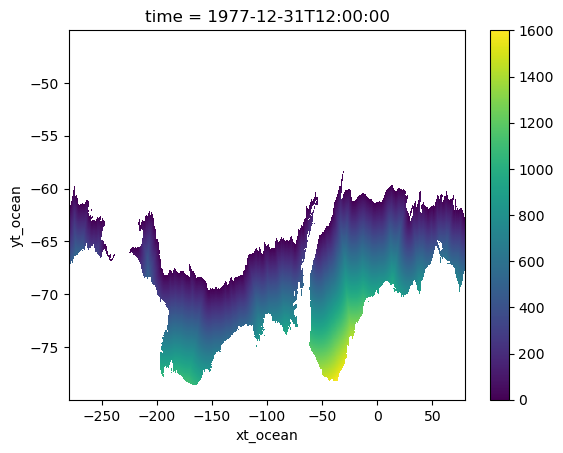

In [37]:
dist_ice_t1 = xr.DataArray(data = distances,
                           dims = ['yt_ocean', 'xt_ocean'],
                           coords = {'yt_ocean': ice_10.yt_ocean.values,
                                     'xt_ocean': ice_10.xt_ocean.values},
                           name = 'dist')

#Note that we use the first time step to create the mask
dist_ice_t1 = xr.where(var_ice[0] >= 0.1, dist_ice_t1, np.nan)

#Checking results
dist_ice_t1.plot()

## Calculating results for other time steps
We will need to get sea ice edge coordinates for the next time step and calculate distances. There is no need to extract grid coordinates again.

In [39]:
#Getting the indices for pixel with maximum value along yt_ocean dimension
ice_yt = ice_10.yt_ocean[ice_10.isel(time = 1).argmax(dim = 'yt_ocean')]
ice_coords2 = np.vstack([ice_yt, ice_10.xt_ocean]).T

#Checking results
ice_coords2

array([[ -66.19813958, -279.95      ],
       [ -66.19813958, -279.85      ],
       [ -66.19813958, -279.75      ],
       ...,
       [ -66.24037894,   79.75      ],
       [ -66.24037894,   79.85      ],
       [ -66.19813958,   79.95      ]])

In [40]:
#First we set up our Ball Tree. Coordinates must be given in radians.
ball_tree = BallTree(np.radians(ice_coords2), metric = 'haversine')

#The nearest neighbour calculation will give two outputs: distances and indices
distances, indices = ball_tree.query(grid_coords, return_distance = True)

In [41]:
#Transforming to km
distances = distances*6371

#Reshaping data
distances = distances.reshape(ice_10[0].shape)

#Check results
distances

array([[1278.09465308, 1278.63800404, 1279.18721329, ..., 1276.4998398 ,
        1277.02556206, 1277.55716944],
       [1273.58502541, 1274.13254532, 1274.68596582, ..., 1271.97796063,
        1272.50772402, 1273.04341528],
       [1269.07673739, 1269.62845484, 1270.18611544, ..., 1267.45733672,
        1267.99116912, 1268.5309724 ],
       ...,
       [2186.28858145, 2185.09036325, 2183.90893797, ..., 2189.98369063,
        2188.73527578, 2187.50356245],
       [2194.03858308, 2192.84295316, 2191.66408355, ..., 2197.72573413,
        2196.48000399, 2195.25094344],
       [2201.7987959 , 2200.60574027, 2199.42941253, ..., 2205.4780316 ,
        2204.23497177, 2203.00854974]])

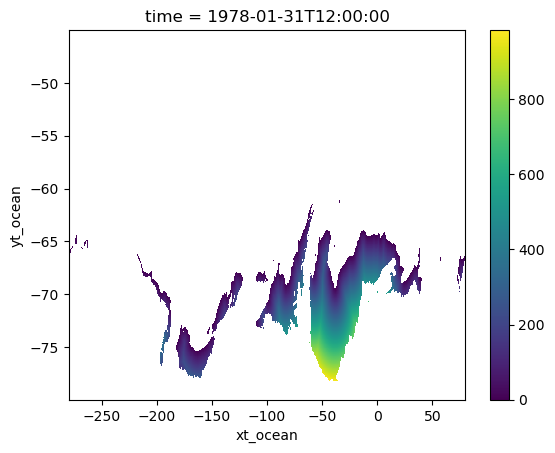

In [42]:
dist_ice_t2 = xr.DataArray(data = distances,
                           dims = ['yt_ocean', 'xt_ocean'],
                           coords = {'yt_ocean': ice_10.yt_ocean.values,
                                     'xt_ocean': ice_10.xt_ocean.values},
                           name = 'dist')

#Note that we use the first time step to create the mask
dist_ice_t2 = xr.where(var_ice[1] >= 0.1, dist_ice_t2, np.nan)

#Checking results
dist_ice_t2.plot()

## Stacking results into one data array

In [44]:
dist_ice = xr.concat([dist_ice_t1, dist_ice_t2], dim = 'time')
dist_ice

<xarray.DataArray (time: 2, yt_ocean: 713, xt_ocean: 3600)>
dask.array<concatenate, shape=(2, 713, 3600), dtype=float64, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1977-12-31T12:00:00 1978-01-31T12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04

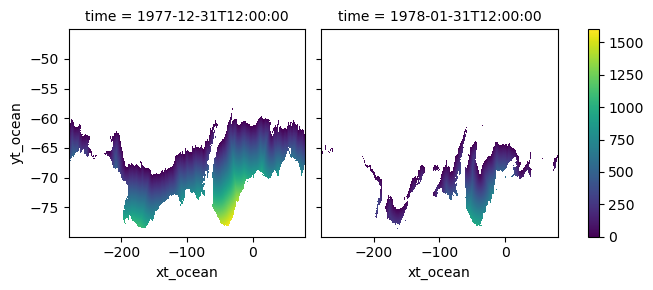

In [45]:
dist_ice.plot(col = 'time')

You are done! You should be able to follow the same workflow to calculate distances to any line/point of your interest.